<a href="https://colab.research.google.com/github/sfiddes/teaching/blob/main/Clustering101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro**

This notebook steps through k-means and hierachical clustering in python using the Palmer Penguins data set and SciKit-Learn. It has been set up to run via google collaboratory, so no intallation on your local computer is required. Unfortunatly, to take advantage of this, you will need a google account. Alternativly, you can download the notebook and run it locally, if you have the required packages installed. 

This notebook assumes little knowlege of python. It has been set up to encourage you to have a go at writing some of the code yourself (whereever there is a cell with only commented out # text in it),  but examples/answers can be found via the 'show code' buttons.

More info: 
https://scikit-learn.org/stable/modules/clustering



# **Set-up**
- Install some non-default packages - the dataset Palmer Penguins

- Import the packages that we want to use: including:
  - Basic python packages for math, data handling, plotting (numpy, pandas matplotlob, seaborn)
  - SciKit-Learn - the home of lots of great machine learning packages 
  - Our dataset - Palmer Penguins


In [5]:
pip install palmerpenguins

In [ ]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram

from palmerpenguins import load_penguins

#**Data**
Import the data and take a look at it. 
- The data has been loaded as a Pandas DataFrame
- You can see that there are both categorical and quantitative metrics 
- Try plotting some of the data 


**Questions**
- What will you try to predict? 
- What will you use to predict it? 
- Are your predictors normally discributed (or close enough?) 

In [7]:
# Import our dataframe - we call it penguins
penguins = load_penguins()

In [8]:
# Print dataframe (can also use dataframe.head() or dataframe.tail(), or dataframe.variable to isolate columns)
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Plot a scatter plot (using seaborn)
- Try to plot a few different variables (eg. predictors) and categories (what we want to predict)
- Can you find a good combination? 

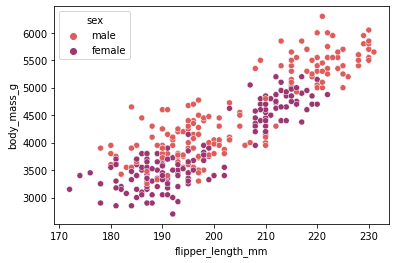

In [9]:
sns.scatterplot(data=penguins,x='flipper_length_mm',y='body_mass_g',hue='sex',palette='flare');  # change the x, y and hue variables

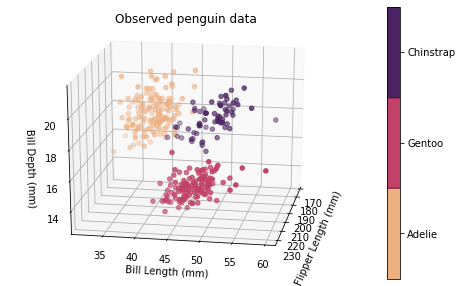

In [10]:
#@title Plot a 3D scatter plot { display-mode: "both" }
c = penguins.species.copy() # need to make categorial groups quantitative [0,1,2]
c[np.where(c=='Adelie')[0]] = 0
c[np.where(c=='Gentoo')[0]] = 1
c[np.where(c=='Chinstrap')[0]] = 2

fig = plt.figure(figsize=(8,5)) # initialise figure
ax = plt.axes(projection='3d')
p = ax.scatter3D(penguins.flipper_length_mm,    # plot in 3D: x
                 penguins.bill_length_mm,       # y
                 penguins.bill_depth_mm,        # z
                 c=c,                           # c (colour)
                 cmap=sns.color_palette('flare',as_cmap=True)); 
cbar = plt.colorbar(p,drawedges=True,ticks=[0,1,2],      # add the colour bar 
                    boundaries=np.arange(-0.5,3.5,1)); 
cbar.set_ticklabels(['Adelie','Gentoo','Chinstrap']) # set color bar tick labels (so not 0,1,2)
ax.view_init(20, 10) # make the viewing angle more optimal
ax.set_xlabel('Flipper Length (mm)');
ax.set_ylabel('Bill Length (mm)');
ax.set_zlabel('Bill Depth (mm)');
plt.title('Observed penguin data');


See if the data you want to use as predictors are normally distributed

In [11]:
# Try your own distribution plot here. Hint: sns.kdeplot(data=dataframe, x=var1, hue=var2) 

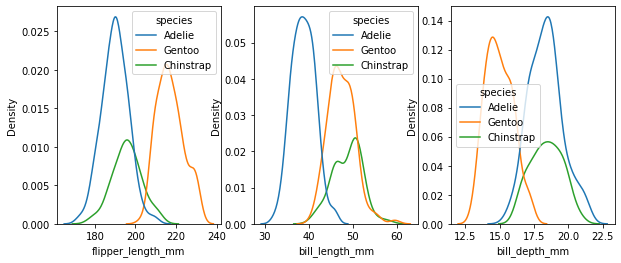

In [12]:
#@title Distribution plot example { display-mode: "both" }
fig, axes = plt.subplots(1,3,figsize=(10,4))
sns.kdeplot(data=penguins, x="flipper_length_mm", hue="species", ax=axes[0]); 
sns.kdeplot(data=penguins, x="bill_length_mm", hue="species", ax=axes[1]); 
sns.kdeplot(data=penguins, x="bill_depth_mm", hue="species", ax=axes[2]); 

# **Prep your data for clustering:**
- Select the predictors (features) you want to use 
- Normalise the data, otherwise the largest field will dominate (because we are using the Eucludian distance)


- I've chosen three features to cluster on (see below) 


In [13]:
features = ['bill_length_mm','bill_depth_mm','flipper_length_mm']

In [14]:
data = penguins[features].dropna().copy() # select the features from the orignal dataframe
X = data.to_numpy() # convert them into a numpy array 
X.shape # check what shape X is 

(342, 3)

In [15]:
XNorm = preprocessing.normalize(X,axis=0,) # normalise each feature
XNorm.min(axis=0), XNorm.max(axis=0) # Check data, eg. see that it is between 0 and 1

(array([0.03921848, 0.04103108, 0.04617901]),
 array([0.07281686, 0.06734108, 0.06201948]))

# **Choosing the number of clusters**

Regardless of clustering method, we need to pre-assign the number of clusters. 

By using the penguins dataset, we already know what we are trying to predict and so we have an idea of how many clusters to choose (i.e we know the stucture of the data). In many instances, we don't know this already, and so have to estimate how many clusters to use. In these cases, there is no right or wrong answer. There are a few guidence metrics, but it ultimatly comes down to you and your knowlege of the data. 

- I've chosen to predict species - we know there are 3 groups
- Change if you're predicting something else (eg. sex), or just want to see what happens! 

In [16]:
n = 3 # number of clusters 

Let's look at some guidance metrics for this choice: 
- Calinski Harabasz Score: The larger the score the more dense/separated the clusters 
- Silhoette Score: The higher the score the more well defined the clusters are
- Davies-Bouldin Index: Values closer to zero indicate less similarity between clusters 

Read more about these and others here: https://scikit-learn.org/stable/modules/clustering#clustering-performance-evaluation


In [17]:
#@title Cluster number metrics 
for k in range(2,6):
  kmeans = KMeans(n_clusters=k, random_state=0).fit(XNorm)
  print('n =',k) 
  print('Calinski Harabasz Score = ', metrics.calinski_harabasz_score(XNorm, kmeans.labels_))
  print('Silhoette Score = ', metrics.silhouette_score(XNorm, kmeans.labels_, metric='euclidean'))
  print('Davies-Bouldin Index = ', metrics.davies_bouldin_score(XNorm, kmeans.labels_))
  print('  ')



n = 2
Calinski Harabasz Score =  370.97164263006965
Silhoette Score =  0.4761356045102751
Davies-Bouldin Index =  0.8533180170557482
  
n = 3
Calinski Harabasz Score =  444.9276059960578
Silhoette Score =  0.5163611138994585
Davies-Bouldin Index =  0.7354763324210091
  
n = 4
Calinski Harabasz Score =  382.5491032860681
Silhoette Score =  0.41995777756257374
Davies-Bouldin Index =  0.9379787314437449
  
n = 5
Calinski Harabasz Score =  395.3073194981979
Silhoette Score =  0.38055890480420895
Davies-Bouldin Index =  0.9396350746978545
  


We can see very clearly in this case that three clusters is the optimal number. Be warned however, often these metrics give different answers and are entirly unhelpful (for example see Section 2.5 in https://www.publish.csiro.au/es/pdf/ES20003), hence you often have to decide for yourself. 

#**K-means clustering**

K-means aims to minimise the within-cluster sum-of-squares and uses an iterative processes to find the best fit (according to a threshold). Read more here; https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In this section we:  
- Run through K-means 
- Look at some of the outputs 
- Plot 

In [18]:
kmeans = KMeans(n_clusters=n, random_state=0).fit(XNorm) # Perform clustering 

In [19]:
kmeans.cluster_centers_ # The centres (means) of each cluster (rembering that the data was normalised)

array([[0.04731826, 0.05717192, 0.05091631],
       [0.0579253 , 0.04691085, 0.05824327],
       [0.06022727, 0.05838876, 0.05291111]])

In [20]:
kmeans.labels_ # the label assigned to each data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2,

In [21]:
data['k-means species']=kmeans.labels_ # Add the labels into the dataframe holding the predictors 

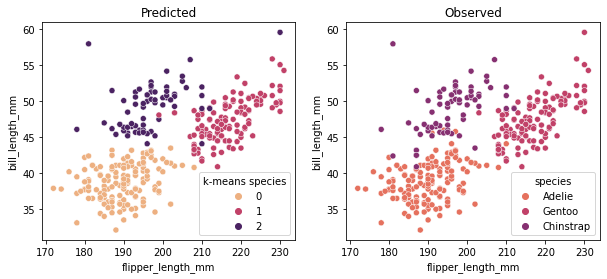

In [22]:
#@title Plot 2D scatter plots
#@markdown - If you are using different predictors to my example, you may have to alter these plots

fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(data=data,x='flipper_length_mm',y='bill_length_mm',hue='k-means species',palette='flare',ax = axes[0]);
axes[0].set_title('Predicted')

sns.scatterplot(data=penguins,x='flipper_length_mm',y='bill_length_mm',hue='species',palette='flare',ax = axes[1]);
axes[1].set_title('Observed');

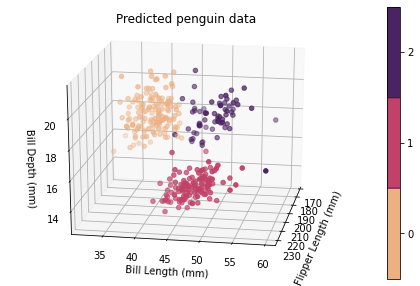

In [23]:
#@title Make a 3D scatter plot { display-mode: "both" }
#@markdown - Again - if you have chosen differnt predictors, you may need to alter
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
p = ax.scatter3D(data['flipper_length_mm'], 
                 data['bill_length_mm'], 
                 data['bill_depth_mm'], 
                 c=data['k-means species'], 
                 cmap=sns.color_palette('flare',as_cmap=True)); 
cbar = plt.colorbar(p,drawedges=True,ticks=[0,1,2],boundaries=np.arange(-0.5,3.5,1)); 
ax.view_init(20, 10) 
ax.set_xlabel('Flipper Length (mm)');
ax.set_ylabel('Bill Length (mm)');
ax.set_zlabel('Bill Depth (mm)');
plt.title('Predicted penguin data');


# **Evaluate**

To evaluate how well the k-means model has performed we can look at: 
- The means of the observed vs predicted clusters
- Plot a confusion matrix


**For each of these metrics, we need to make sure the labels refer to the same species!**

First up: look at the means. Using the Pandas DataFrames makes this really easy

In [24]:
mns = data.groupby('k-means species').mean()[features]  # need to assign the correct species to the predicted labels
mns.index = ['Adelie','Gentoo','Chinstrap']             # if you have changed the clustering method, you will need to adjust this
print('Predicted')
print(mns)                                              # print the predicted means
print(' ')
print('Observed')
print(penguins.groupby('species').mean()[features])     # print the observed means for each species 
print(' ')
print('Differences')
print(penguins.groupby('species').mean()[features]-mns) # print the differences

Predicted
           bill_length_mm  bill_depth_mm  flipper_length_mm
Adelie          38.729605      18.253289         189.644737
Gentoo          47.411382      14.977236         216.934959
Chinstrap       49.295522      18.641791         197.074627
 
Observed
           bill_length_mm  bill_depth_mm  flipper_length_mm
species                                                    
Adelie          38.791391      18.346358         189.953642
Chinstrap       48.833824      18.420588         195.823529
Gentoo          47.504878      14.982114         217.186992
 
Differences
           bill_length_mm  bill_depth_mm  flipper_length_mm
Adelie           0.061785       0.093068           0.308906
Chinstrap       -0.461699      -0.221203          -1.251097
Gentoo           0.093496       0.004878           0.252033


Now let's look at a confusion matrix: 
- We've already defined a quantitiatve list of of observed species for the 3D scatter plot, c 
- We need to make sure that the 0,1,2s of the predicted model refer to the same as that for the observed. If you've altered the features/cluster numbers - this may need to be changed! 
  - Adelie=0
  - Gentoo=1
  - Chinstrap=2

In [25]:
# Get the observed species 
features2 = features.copy()
features2.append('species')
obs = penguins[features2].dropna().copy()['species']

# And the predicted species 
pred = data['k-means species'].copy()
pred[pred==0] = 'Adelie'
pred[pred==1] = 'Gentoo'
pred[pred==2] = 'Chinstrap'

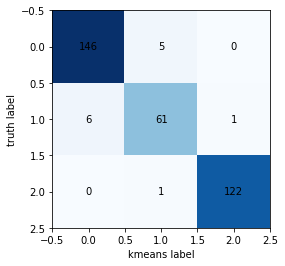

In [29]:
cm = metrics.confusion_matrix(y_true=obs, y_pred=pred)
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()



# **Hierachical - Agglomerative Clustering**

We can re-do the clusters using a range of different agglomerative clustering methods. Agglomerative clustering is a bottom up approach, where each sample is it's own cluster to start with and at each iteration may be merged with another, until there is only one cluster. 

This can be of benifit for data in which there is sample-connectivity, eg. spatial data. You can see an example of agglomerative clutering in this paper: https://www.publish.csiro.au/es/pdf/ES20003

There are a number of agglomerative clutering methods, which use different 'linkages', i.e. what they try to minimize to form the clusters. You can read about them here: https://scikit-learn.org/stable/modules/clustering#hierarchical-clustering

In this notebook, we will just look at the Ward linkage method, which is very similar to that of k-means in that it minimizes the sum of squared differences within all clusters. 

Here we will: 
- Look at the stucture of the data to help understand how many clusters we should choose
- Compare the Ward method to k-means


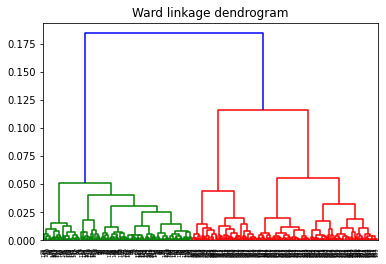

In [27]:
#@title Look at the stucture of the data { display-mode: "both" }
#@markdown - This plot is called a dendrogram
#@markdown - Where there are large 'distances' between merges of clusters implies less similarity between clusters

# - We first need to define a funciton to plot the dendrogram
# - Then we need to slightly alter the clustering code to tell it to iterate 
#   through all groupings

# Function
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    ''' This was taken from:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    '''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# create model 
model = AgglomerativeClustering(linkage='ward',n_clusters=None,distance_threshold=0).fit(XNorm)

# plot
plot_dendrogram(model)
plt.title('Ward linkage dendrogram');

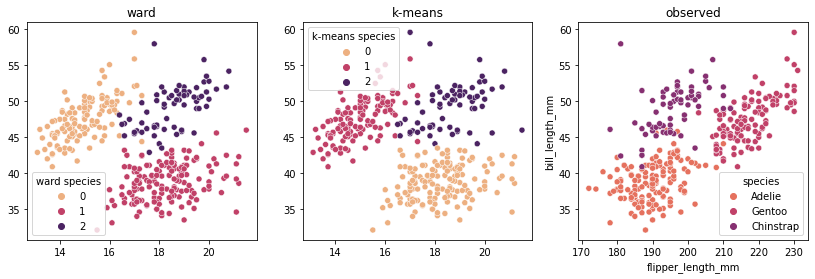

In [28]:
#@title Agglomerative clustering
#@markdown - This is using the Ward linkage method
#@markdown - You can change this to look at the other linkage methods 


link = 'ward' # or try: 'average','single' or 'complete'

fig, axes = plt.subplots(1,3,figsize=(14,4))

# run the agglomerate model
agglom = AgglomerativeClustering(linkage=link,n_clusters=n).fit(XNorm)
data['{} species'.format(link)] = agglom.labels_

# plot
sns.scatterplot(x=X[:,1],y=X[:,0],hue=data['{} species'.format(link)],
                palette='flare',ax = axes[0]);
axes[0].set_title(link)

sns.scatterplot(x=X[:,1],y=X[:,0],hue=data['k-means species'],
                palette='flare',ax = axes[1]);
axes[1].set_title('k-means')

sns.scatterplot(data=penguins,x='flipper_length_mm',y='bill_length_mm',hue='species',
                palette='flare',ax = axes[2]);
axes[2].set_title('observed');